<a href="https://colab.research.google.com/github/geraldalivia/Temperature-TimeSeries/blob/main/TimeSeries_Temperature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Library and Depedencie Needs

In [37]:
# Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Load
from google.colab import drive

# Data Preparation
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

# Data Split
from sklearn.model_selection import train_test_split

# Build Model
from tensorflow.keras.layers import LSTM, Dense
from xgboost import XGBRegressor

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

Cell code di atas menampilkan library yang diperlukan dalam pengerjaan proyek ini. Beberapa library utama yang digunakan meliputi pandas, numpy, matplotlib, dan seaborn. Library pandas dan numpy berguna untuk manipulasi, analisis, dan komputasi data. Sementara matplotlib dan seaborn digunakan untuk plotting dan visualisasi data.

Proyek ini juga menggunakan akses Google Drive melalui Colab untuk memuat dataset. Selain itu, terdapat beberapa fungsi preprocessing dan modeling seperti MinMaxScaler dan Sequential untuk preprocessing data, train_test_split untuk membagi data menjadi set training dan testing, LSTM, Dense dan XGBRegressor untuk pemodelan machine learning, serta MAE, dan MSE untuk evaluasi model.

## Data Loading

In [2]:
# Load dataset from drive
drive.mount('/content/drive')

raw_data = pd.read_csv('/content/drive/MyDrive/Submission/Applied Machine Learning/Project 1/Dataset/MLTempDataset1.csv')
raw_data.head()

Mounted at /content/drive


,Unnamed: 0,Datetime,Hourly_Temp
0,0,2022-01-04 00:00:00,20.867
1,1,2022-01-04 01:00:00,21.000
2,2,2022-01-04 02:00:00,20.867
3,3,2022-01-04 03:00:00,20.650
4,4,2022-01-04 04:00:00,20.400


Cell code di atas untuk menghubungkan drive melalui colab yang berguna untuk melakukan load dataset yang diambil dari file 'MLTempDataset1.csv', yang kemudian menampilkan 5 baris awal dalam dataframe

## Data Understanding

In [3]:
# Melihat komposisi dataset
row = raw_data.shape[0]
column = raw_data.shape[1]

print("Dataset ini memiliki", row, "baris dan", column, "kolom")

Dataset ini memiliki 7056 baris dan 3 kolom


Code cell di atas berguna untuk memahami struktur dataset dari raw_data yang digunakan. Pada dataset tersebut teridiri atas 7056 baris dan 3 kolom.

In [4]:
# Mengetahui tipe data masing-masing kolom
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7056 entries, 0 to 7055
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   7056 non-null   int64  
 1   Datetime     7056 non-null   object 
 2   Hourly_Temp  7056 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 165.5+ KB


Cell code di atas untuk mengetahui tipe data setiap kolom yang ada pada dataset raw_data. Selain itu, kita dapat melihat bahwa tidak ada kolom dengan nilai yang hilang (tidak ada missing value).

In [5]:
# Mengetahui statistik pada dataset
raw_data.describe()

,Unnamed: 0,Hourly_Temp
count,7056.000000,7056.000000
mean,3527.500000,21.867468
std,2037.036082,6.737313
min,0.000000,5.350000
25%,1763.750000,18.400000
50%,3527.500000,24.033000
75%,5291.250000,26.333000
max,7055.000000,36.500000


Cell code di atas untuk menampilkan perhitungan statistik tiap kolom, terutama kolom bertipe data numerik. Dapat dilihat bahwa perhitungan statistik yang ditampilkan diantaranya adalah jumlah, mean, nilai minimum, nilai maksimum, hingga standar deviasi.

## Exploratory Data Analysis

In [6]:
# Mengecek data dengan missing value
missing1 = raw_data.isnull().sum()
print("Missing values:\n", missing1)

Missing values:
 Unnamed: 0     0
Datetime       0
Hourly_Temp    0
dtype: int64


Code Cell di atas untuk melakukan pengecekan missing value atas nilai yang hilang pada dataset raw_data

In [7]:
# Mengecek adanya data duplikat
duplicated1 = raw_data.duplicated().sum()
print("Duplicated data:", duplicated1)

Duplicated data: 0


Code Cell di atas untuk melakukan pengecekan data yang yang terdapat duplikat pada dataset raw_data

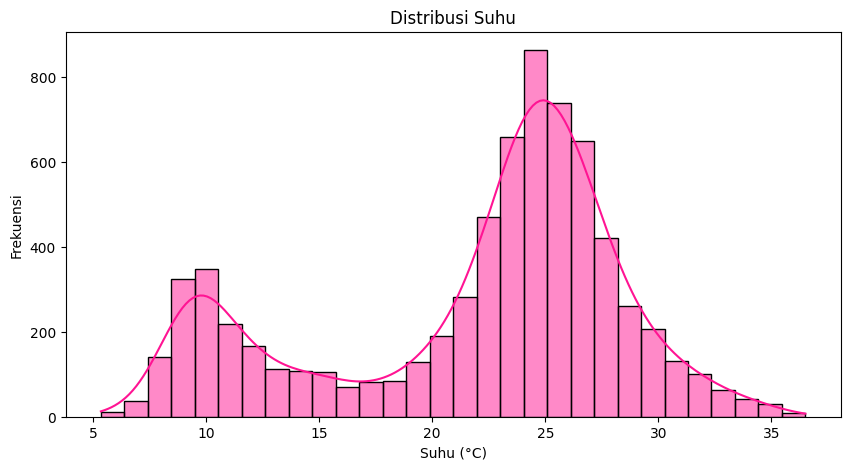

In [11]:
# Mengetahui distribusi temperature
plt.figure(figsize=(10, 5))
sns.histplot(raw_data['Hourly_Temp'], bins=30, kde=True, color='deeppink')
plt.title('Distribusi Suhu')
plt.xlabel('Suhu (°C)')
plt.ylabel('Frekuensi')
plt.show()

Cell code tersebut untuk menunjukkan distribusi data dalam bentuk plot histogram kurva dengan x adalah suhu.  <br>

**Insight:**
- Distribusi bimodal, tidak terlalu skewed yang menandakan data distribusi cukup baik
- Range nilai distribusi bagus, tidak ada outlier ekstrem
- Terdapat dua puncak atau Favorit Suhu (10°C dan 24-25°C), yang menandakan pola siang-malam yang berguna untuk model forecasting karena menunjukkan pola yang dapat diprediksi


## Data Preparation

In [17]:
# Mengubah nama kolom
raw_data = raw_data.rename(columns={
    'Unnamed: 0': 'Number',
    'Datetime': 'Timestamp',
    'Hourly_Temp': 'Temperature'
})
raw_data.head()

,Number,Timestamp,Temperature
0,0,2022-01-04 00:00:00,20.867
1,1,2022-01-04 01:00:00,21.000
2,2,2022-01-04 02:00:00,20.867
3,3,2022-01-04 03:00:00,20.650
4,4,2022-01-04 04:00:00,20.400


Code cell di atas untuk mengubah nama (rename) kolom dalam dataset raw_data. Kolom awal terdiri dari Unnamed: 0, Datetime, dan Hourly_Temp. Kolom dengan nama baru terdii dari Number, Timestamp, dan Temperature.

In [18]:
# Mengatur kolom Timestamp agar menjadi datetime untuk memudahkan ploting
if 'Timestamp' in raw_data.columns:
    raw_data['Timestamp'] = pd.to_datetime(raw_data['Timestamp'])

raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7056 entries, 0 to 7055
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Number       7056 non-null   int64         
 1   Timestamp    7056 non-null   datetime64[ns]
 2   Temperature  7056 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 165.5 KB


Code cell diatas untuk mengubah tipe data pada kolom Timestamp yang awalnya object menjadi datetime.

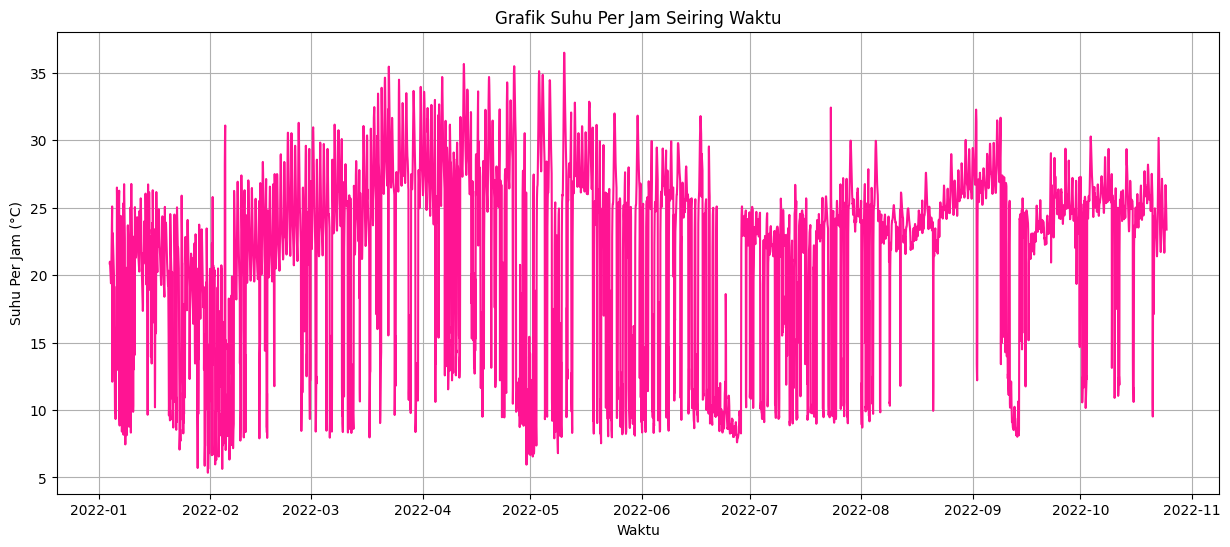

In [20]:
# Plot deret waktu suhu per jam
plt.figure(figsize=(15, 6))
sns.lineplot(x='Timestamp', y='Temperature', data=raw_data, color='deeppink')
plt.title('Grafik Suhu Per Jam Seiring Waktu')
plt.xlabel('Waktu')
plt.ylabel('Suhu Per Jam (°C)')
plt.grid(True)
plt.show()

Cell code diatas untuk menampilkan visualisasi Time Series suhu harian <br>

**Insight:**
- Terdapat pola musiman, diantaranya:
  - Musim Dingin (Jan-Feb): suhu lebih rendah berkisar ~8-27°C
  - Musim Semi/Panas (Mar-Jun): Suhu meningkat ~15-35°C dengan puncak terjadi di bulan April-Mei
  - Musim Gugur (Jul-Nov): Suhu menurun dari ~30°C ke ~25°C
- Fluktuasi data yang menandakan perbedaan waktu siang-malam
- Range suhu berkisar 5-37°C menunjukkan pola iklim dengan variasi musiman yang jelas

In [70]:
###
## Membuat Sliding Window (Squence) dan Melakukan Normalisasi
###

# Setup Normalisasi
normalize = True
scaler = MinMaxScaler(feature_range=(-1, 1))

# Membuat fungsi Sliding Window
def sliding_windows(y_var, data, seq_length):
    # Validasi Input
    if y_var is None:
        raise ValueError("y_var belum diatu")

    # Ekstraksi dan Reshape Data
    target_ori = data[y_var].values.reshape(-1, 1)

    # Melakukan Normalisasi
    if normalize:
        # Normalisasi pada data target
        new_data = scaler.fit_transform(target_ori)
    else:
        # Jika tidak melakukan nomalisasi, kembali gunakan data asli
        new_data = target_ori

    # Inisialisasi List
    x = [] # menyimpan input
    y = [] # menyimpan target

    # Loop Sliding Window
    for i in range(len(new_data) - seq_length):
        # Ambil 'seq_length' data sebagai input (X)
        _x = new_data[i : (i + seq_length)]
        x.append(_x)

        # Ambil data berikutnya sebagai target (Y)
        _y = new_data[i + seq_length]
        y.append(_y)

    # Konversi ke NumPy Array
    return np.array(x), np.array(y)

Cell Code di atas berguna untuk membuat Sliding Window. Sliding Window digunakan untuk mengubah data time-series menjadi format yang sesuai untuk proses develop ML (dalam projek ini menggunakan LSTM danXGBoost ). Dengan teknik sliding window, kita menggunakan N data point sebelumnya untuk memprediksi data point berikutnya.


In [25]:
###
## Verifikasi Sequence
###

# Setup Parameter
seq_length = 6
x, y = sliding_windows("Temperature", raw_data, seq_length)

print(f"\n Bentuk Sequence yang Dibuat (seq_length = {seq_length})")
print("X (sequence input):", x.shape)
print("Y (nilai target):", y.shape)

# Menampilkan beberapa sampel dar X dan Y untuk verifikasi
print("\n Menampilan X (Sequence Input dari Sliding Windows)")
print(x[:3])
print("\n Menampilkan Y (Nilai Target dari Sliding Windows)")
print(y[:3])


 Bentuk Sequence yang Dibuat (seq_length = 6)
X (sequence input): (7050, 6, 1)
Y (nilai target): (7050, 1)

 Menampilan X (Sequence Input dari Sliding Windows)
[[[-0.00372392]
  [ 0.00481541]
  [-0.00372392]
  [-0.0176565 ]
  [-0.03370787]
  [-0.0529695 ]]

 [[ 0.00481541]
  [-0.00372392]
  [-0.0176565 ]
  [-0.03370787]
  [-0.0529695 ]
  [-0.07223114]]

 [[-0.00372392]
  [-0.0176565 ]
  [-0.03370787]
  [-0.0529695 ]
  [-0.07223114]
  [-0.09149278]]]

 Menampilkan Y (Nilai Target dari Sliding Windows)
[[-0.07223114]
 [-0.09149278]
 [-0.09791332]]


Cell code di atas menampilkan implementasikan dan memverifikasi hasil dari fungsi sliding_windows yang sudah didefinisikan sebelumnya.

In [28]:
# Membagi data train dan test untuk LSTM
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

print("Bentuk X_train:", X_train.shape)
print("Bentuk y_train:", y_train.shape)
print("Bentuk X_test:", X_test.shape)
print("Bentuk y_test:", y_test.shape)

Bentuk X_train: (5640, 6, 1)
Bentuk y_train: (5640, 1)
Bentuk X_test: (1410, 6, 1)
Bentuk y_test: (1410, 1)


Cell code tersebut untuk melakukan data splitting pada dataset dengan proporsi 80:20, 80% untuk pelatihan (training) dan 20% untuk pengujian (testing).

In [38]:
# Membagi data train dan test untuk XGBBoost
X_train_xgb = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test_xgb = X_test.reshape(X_test.shape[0], X_test.shape[1])
y_train_xgb = y_train.flatten() # Mengubah y_train dari (num_samples, 1) menjadi (num_samples,)
y_test_xgb = y_test.flatten()   # Mengubah y_test dari (num_samples, 1) menjadi (num_samples,)

print("Bentuk X_train_xgb:", X_train_xgb.shape)
print("Bentuk y_train_xgb:", y_train_xgb.shape)
print("Bentuk X_test_xgb:", X_test_xgb.shape)
print("Bentuk y_test_xgb:", y_test_xgb.shape)

Bentuk X_train_xgb: (5640, 6)
Bentuk y_train_xgb: (5640,)
Bentuk X_test_xgb: (1410, 6)
Bentuk y_test_xgb: (1410,)


Cell code tersebut berfungsi untuk menyesuaikan bentuk (shape) dari data pelatihan dan pengujian (X_train, X_test, y_train, y_test) agar sesuai dengan format input yang diharapkan oleh model XGBoost Regressor.

## Modelling

In [30]:
###
## Model LSTM
###

model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(units=1)) # units = 1 karena memprediksi satu nilai suhu berikutnya

Code Cell tersebut bertujuan untuk membangun model LSTM (Long Short-Term Memory) untuk prediksi deret waktu, dalam hal ini prediksi nilai suhu berikutnya berdasarkan data sebelumnya. <br>

**Notes:**
- Sequential() : Membuat model sekuensial yang lapisannya ditambahkan satu per satu secara berurutan.
- model.add(LSTM(...)) : Menambahkan lapisan LSTM (Long Short-Term Memory) ke model.
- units=50 : Jumlah neuron/unit di LSTM layer adalah 50.
- activation='relu' : Menggunakan fungsi aktivasi ReLU
- seq_length : Jumlah langkah waktu (timesteps) yang digunakan untuk memprediksi nilai selanjutnya.
- 1 : Setiap timestep hanya berisi satu suhu.
- model.add(Dense(...)) : Menambahkan lapisan Dense (fully connected) sebagai output layer.
- units=1 : Model hanya akan memprediksi satu nilai suhu pada timestamp berikutnya.

In [32]:
# Mengkompilasi Model LSTM
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Cell code tersebut berguna untuk mengkompilasi dan menampilkan ringkasan model LSTM yang dibuat.

**Notes:**
- compile() : langkah sebelum melatih model.
- optimizer='adam': Adam (Adaptive Moment Estimation) adalah algoritma optimasi.
- loss='mse': MSE (Mean Squared Error) digunakan untuk mengukur selisih antara nilai sebenarnya dan prediksi.

In [33]:
# Melatih Model LSTM
history = model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
5640/5640 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 0.0549
Epoch 2/100
5640/5640 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - loss: 0.0362
Epoch 3/100
5640/5640 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.0340
Epoch 4/100
5640/5640 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.0361
Epoch 5/100
5640/5640 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 0.0349
Epoch 6/100
5640/5640 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 0.0313
Epoch 7/100
5640/5640 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.0315
Epoch 8/100
5640/5640 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 0.0334
Epoch 9/100
5640/5640 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.0342
Epoch 10/100
5640/5640 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.0324
Epoch 11/100
5640/5640 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 0.0316
Epoch 12/100
5640/5640 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.0324
Epoch 13/100
5640/5640 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 0.0312
Epoch 14/100
5640/5640 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 0.0323
E

Code Cell tersebut untuk melatih model LSTM. <br>
**Notes:**
- X_train: Data input suhu untuk pelatihan.
- y_train: Output suhu selanjutnya yang ingin diprediksi.
- epochs=100: Model akan melihat seluruh dataset sebanyak 100 kali.
- batch_size=1: Model akan memperbarui bobotnya setelah setiap 1 sampel.
- verbose=1: Menampilkan progress pelatihan baris per epoch


In [39]:
###
## Model XGBoostRegressor
###

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_model.fit(X_train_xgb, y_train_xgb)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

Cell code tersebut untuk menginisialisasi atau membuat model XGBoost Regressor. <br>

**Notes:**
- XGBRegressor(): library xgboost.
- n_estimators=100: hyperparameter yang menentukan jumlah pohon keputusan (decision trees) yang akan dibangun oleh algoritma boosting.
- learning_rate=0.1: hyperparameter yang mengontrol ukuran langkah saat mengoptimalkan model.
- random_state=42: generator angka acak.
- n_jobs=-1: hyperparameter yang mengatur jumlah thread CPU yang akan digunakan untuk pelatihan.

In [40]:
# Melakukan prediksi pada data testing
xgb_pred_scaled = xgb_model.predict(X_test_xgb)

Code cell ini berfungsi untuk membuat prediksi menggunakan model XGBoost yang telah dilatih (xgb_model) pada data pengujian. <br>

**Notes:**
- X_test_xgb: data input pengujian yang telah disesuaikan bentuknya, yang belum pernah dilihat oleh model selama pelatihan.
- xgb_model.predict(): untuk menghasilkan serangkaian nilai prediksi berdasarkan input X_test_xgb.
- xgb_pred_scaled: menyimpan hasil prediksi, yang masih dalam skala normalisasi (karena data input ke model juga dinormalisasi).

## Evaluation

In [81]:
##
# LSTM
##

# Melakukan prediksi pada data testing
y_pred_scaled_lstm = model.predict(X_test)

# Mengukur kinerja model (skala normalisasi)
mse_lstm = mean_squared_error(y_test, y_pred_scaled_lstm)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_scaled_lstm)

# Inverse transform untuk mendapatkan nilai pada skala asli
y_test_original = scaler.inverse_transform(y_test)
y_pred_original_lstm = scaler.inverse_transform(y_pred_scaled_lstm)

# Mengukur kinerja model (skala asli)
mse_original_lstm = mean_squared_error(y_test_original, y_pred_original_lstm)
rmse_original_lstm = np.sqrt(mse_original_lstm)
mae_original_lstm = mean_absolute_error(y_test_original, y_pred_original_lstm)


##
# XGBoost
##

# Melakukan prediksi pada data testing
xgb_pred_scaled = xgb_model.predict(X_test_xgb)

# Mengukur kinerja model (skala normalisasi)
mse_xgb = mean_squared_error(y_test_xgb, xgb_pred_scaled)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test_xgb, xgb_pred_scaled)

# Inverse transform untuk mendapatkan nilai pada skala asli
y_pred_original_xgb = scaler.inverse_transform(xgb_pred_scaled.reshape(-1, 1))

# Mengukur kinerja model (skala asli)
mse_original_xgb = mean_squared_error(y_test_original, y_pred_original_xgb)
rmse_original_xgb = np.sqrt(mse_original_xgb)
mae_original_xgb = mean_absolute_error(y_test_original, y_pred_original_xgb)


### Melihat komparasi kedua model melalui evaluasi
# Kumpulkan metrik evaluasi untuk kedua model
metrics_df = pd.DataFrame({
    'Metrik': ['MSE (Normalized)', 'RMSE (Normalized)', 'MAE (Normalized)',
               'MSE (Original Scale)', 'RMSE (Original Scale)', 'MAE (Original Scale)'],
    'LSTM': [mse_lstm, rmse_lstm, mae_lstm,
             mse_original_lstm, rmse_original_lstm, mae_original_lstm],
    'XGBoost': [mse_xgb, rmse_xgb, mae_xgb,
                mse_original_xgb, rmse_original_xgb, mae_original_xgb]
})

print("\n~~~~Tabel Komparasi Metrik Evaluasi~~~~~")
print(metrics_df.round(4).to_string(index=False))

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

~~~~Tabel Komparasi Metrik Evaluasi~~~~~
               Metrik   LSTM  XGBoost
     MSE (Normalized) 0.0142   0.0135
    RMSE (Normalized) 0.1193   0.1161
     MAE (Normalized) 0.0508   0.0552
 MSE (Original Scale) 3.4536   3.2711
RMSE (Original Scale) 1.8584   1.8086
 MAE (Original Scale) 0.7910   0.8597


Cell code tersebut bertujuan untuk melakukan proses evaluasi dari model yang telah dilatih. Model yang sebelumnya dibuat yaitu LSTM dan XGBosst dilihat evaluasinya baik dari skala normal (normalized) dan data asli (original scale) berdasarkan 3 metrik evaluasi yang digunakan, yaitu Mean Absolute Error (MAE), Mean Squared Error (MSE), dan Root Mean Squared Error.

**Notes:**
- MAE (Mean Absolute Error): rata-rata kesalahan absolut prediksi terhadap nilai sebenarnya.
- MSE (Mean Squared Error): rata-rata kuadrat kesalahan.
RMSE (Root Mean Squared Error): akar dari MSE.
- R² (R-squared): proporsi variansi target yang dapat dijelaskan oleh fitur.

## Visualisasi

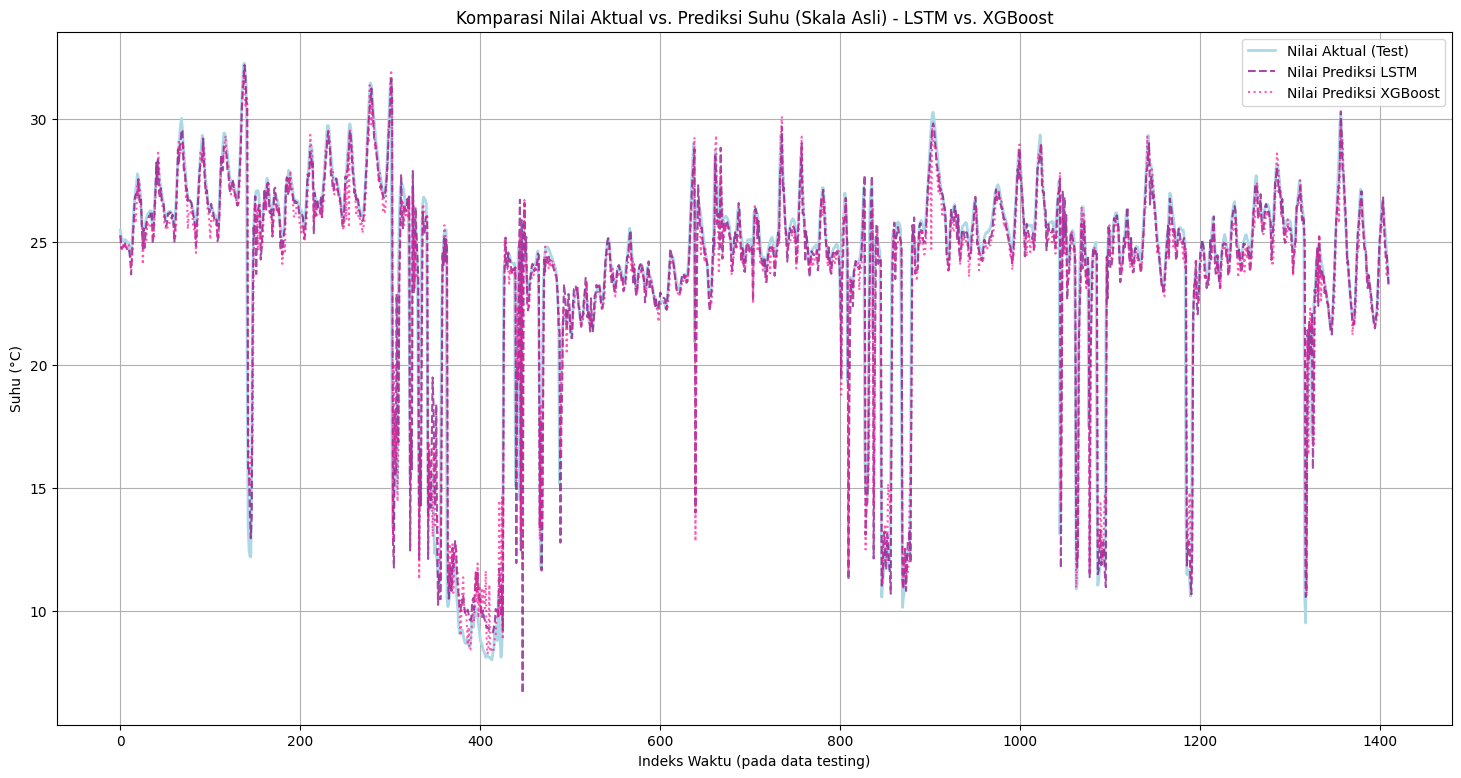

In [85]:
# Komparasi Kdeua Model antara LSTM dan XGBoost
plt.figure(figsize=(18, 9))
plt.plot(y_test_original, label='Nilai Aktual (Test)', color='lightblue', linewidth=2)
plt.plot(y_pred_original_lstm, label='Nilai Prediksi LSTM', color='purple', linestyle='--', alpha=0.7)
plt.plot(y_pred_original_xgb, label='Nilai Prediksi XGBoost', color='deeppink', linestyle=':', alpha=0.7)
plt.title('Komparasi Nilai Aktual vs. Prediksi Suhu (Skala Asli) - LSTM vs. XGBoost')
plt.xlabel('Indeks Waktu (pada data testing)')
plt.ylabel('Suhu (°C)')
plt.legend()
plt.grid(True)
plt.show()

Cell Code tersebut berguna untuk manmpilkan grafik visualisasi dari kedua model berdasarkan 3 metrik, yaitu nilai prediksi untuk LSTM, nilai prediksi untuk XGBoost, dan nilai prediksi aktual.

**Insight:**
Kedua model mengikuti pola Tren umum, yang menandakan kedua model berhasil menangkap pola dasar deret waktu suhu.


## Inference

In [86]:
###
## LSTM
###

new_data_full = scaler.fit_transform(target_original_full)
last_sequence = new_data_full[-seq_length:]
last_sequence = last_sequence.reshape(1, seq_length, 1)

# Lakukan prediksi
next_temp_scaled_lstm = model.predict(last_sequence)

# Inverse transform untuk mendapatkan nilai pada skala asli
next_temp_original_lstm = scaler.inverse_transform(next_temp_scaled_lstm)

print(f"\nPrediksi Suhu Berikutnya (LSTM)")
print(f"Prediksi suhu berikutnya (skala asli): {next_temp_original_lstm[0][0]:.2f} °C")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Prediksi Suhu Berikutnya (LSTM)
Prediksi suhu berikutnya (skala asli): 22.83 °C


Cell Code tersebut merupakan salah satu inferensi prediksi temperature. Data yang diprediksi olehh model LSTM menunjukkan 22.83°C. Data ini berasal dari data terakhir last_sequence, yaitu seq_length (6) 6 data suhu terakhir (yang telah dinormalisasi) untuk memprediksi nilai berikutnya berdasarkan pola yang telah dipelajari. Hasilnya lalu dikembalikan ke satuan asli (°C) dengan inverse_transform(), dan nilainya bergantung pada data terakhir yang digunakan saat inferensi.

In [88]:
###
## XGBoost
###

target_original_full = raw_data['Temperature'].values.reshape(-1, 1)
data_to_use_full = scaler.fit_transform(target_original_full)

last_sequence_xgb = data_to_use_full[-seq_length:]
last_sequence_xgb = last_sequence_xgb.reshape(1, seq_length)

# Lakukan prediksi
next_temp_scaled_xgb = xgb_model.predict(last_sequence_xgb)

# Inverse transform untuk mendapatkan nilai pada skala asli
next_temp_original_xgb = scaler.inverse_transform(next_temp_scaled_xgb.reshape(-1, 1))

print(f"\nPrediksi Suhu Berikutnya (XGBoost)")
print(f"Prediksi suhu berikutnya (skala asli): {next_temp_original_xgb[0][0]:.2f} °C")


Prediksi Suhu Berikutnya (XGBoost)
Prediksi suhu berikutnya (skala asli): 23.12 °C


Cell Code tersebut merupakan salah satu inferensi prediksi temperature. Data yang diprediksi olehh model XGBoost menunjukkan 23.12°C. Data ini berasal dari data terakhir last_sequence, yaitu seq_length (6) 6 data suhu terakhir (yang telah dinormalisasi) untuk memprediksi nilai berikutnya berdasarkan pola yang telah dipelajari. Hasilnya lalu dikembalikan ke satuan asli (°C) dengan inverse_transform(), dan nilainya bergantung pada data terakhir yang digunakan saat inferensi.

In [90]:
### Contoh input manual menggunakan model LSTM

manual_input = np.array([25.0, 24.5, 24.0, 23.5, 23.0, 22.5]).reshape(-1, 1)

# Normalisasi input manual
# Gunakan scaler yang sudah di-fit pada data pelatihan
manual_input_scaled = scaler.transform(manual_input)

# Ubah bentuk untuk input model LSTM
# (1, seq_length, 1) -> 1 sampel, seq_length timesteps, 1 fitur
manual_input_reshaped = manual_input_scaled.reshape(1, seq_length, 1)

# Lakukan prediksi
manual_pred_scaled_lstm = model.predict(manual_input_reshaped)

# Inverse transform untuk mendapatkan nilai pada skala asli
manual_pred_original_lstm = scaler.inverse_transform(manual_pred_scaled_lstm)

print(f"Input manual: {manual_input.flatten()} °C")
print(f"Prediksi suhu berikutnya (LSTM) dari input manual: {manual_pred_original_lstm[0][0]:.2f} °C")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Input manual: [25.  24.5 24.  23.5 23.  22.5] °C
Prediksi suhu berikutnya (LSTM) dari input manual: 21.94 °C


Cell Code tersebut merupakan salah satu implementasi jika melakukan manual input untuk memprediksi temperature/suhu.

**Hasil prediksi suhunya adalah 21.94°C**. Didapatkan dari data imput manual [25.0, 24.5, 24.0, 23.5, 23.0, 22.5]. Pada data ini, terjadi tren penurunansuhu, model LSTM yang telah dilatih pada pola serupa memprediksi kelanjutan tren tersebut. Nilai 21.94°C adalah hasil komputasi setelah input dinormalisasi dan diubah kembali ke skala suhu asli.